In [1]:
import numpy as np
import torch
from mmengine.config import Config
from mmengine.dataset import Compose
from mmengine.runner import Runner
from mmengine.runner.amp import autocast
from mmyolo.registry import RUNNERS
from torchvision.ops import nms


if __name__ == "__main__":
    # load config
    cfg = Config.fromfile(
        "configs/pretrain/yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py"
    )
    cfg.work_dir = "."
    cfg.load_from = "yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth"
    runner = Runner.from_cfg(cfg)
    runner.call_hook("before_run")
    runner.load_or_resume()
    pipeline = cfg.test_dataloader.dataset.pipeline
    runner.pipeline = Compose(pipeline)
    runner.model.eval()

/home/emilia/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


02/21 11:07:19 - mmengine - WARNING - Failed to search registry with scope "mmyolo" in the "log_processor" registry tree. As a workaround, the current "log_processor" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmyolo" is a correct scope, or whether the registry is initialized.
02/21 11:07:19 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) [GCC 9.4.0]
    CUDA available: False
    MUSA available: False
    numpy_random_seed: 279298733
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 1.13.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Gi

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPTextModelWithProjection: ['vision_model.encoder.layers.7.self_attn.k_proj.bias', 'vision_model.post_layernorm.weight', 'vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vision_model.encoder.layers.0.layer_norm2.bias', 'vision_model.encoder.layers.6.mlp.fc1.bias', 'vision_model.encoder.layers.10.mlp.fc2.bias', 'logit_scale', 'vision_model.encoder.layers.6.layer_norm1.bias', 'vision_model.embeddings.position_ids', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.11.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.9.self_attn.v_proj.weight', 'vision_model.encoder.layers.9.self_attn.out_proj.weight', 'vision_model.encoder.layers.10.self_attn.q_proj.bias', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.3.self_attn.k_proj.weight', 'vision_model.encoder.layers.9.sel

02/21 11:07:26 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/21 11:07:26 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(49          ) EMAHook                            
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
after_load_checkpoint:
(49          ) EMAHook                            
 -------------------- 
before_train:
(9           ) YOLOv5ParamSchedulerHook           
(VERY_HIGH   ) RuntimeInfoHook                    
(49          ) EMAHook                            
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHo

In [26]:
import PIL.Image
import supervision as sv

def run_image(
        runner,
        input_image,
        max_num_boxes=100,
        score_thr=0.05,
        nms_thr=0.5,
        class_names=("rail, pole, bolt, fence, wood"),
):
    texts = [[t.strip()] for t in class_names.split(",")] + [[" "]]
    data_info = runner.pipeline(dict(img_id=0, img_path=input_image,
                                     texts=texts))

    data_batch = dict(
        inputs=data_info["inputs"].unsqueeze(0),
        data_samples=[data_info["data_samples"]],
    )

    with autocast(enabled=False), torch.no_grad():
        output = runner.model.test_step(data_batch)[0]
        runner.model.class_names = texts
        pred_instances = output.pred_instances

    keep_idxs = nms(pred_instances.bboxes, pred_instances.scores, iou_threshold=nms_thr)
    pred_instances = pred_instances[keep_idxs]
    pred_instances = pred_instances[pred_instances.scores.float() > score_thr]

    if len(pred_instances.scores) > max_num_boxes:
        indices = pred_instances.scores.float().topk(max_num_boxes)[1]
        pred_instances = pred_instances[indices]
    output.pred_instances = pred_instances

    pred_instances = pred_instances.cpu().numpy()
    detections = sv.Detections(
        xyxy=pred_instances['bboxes'],
        class_id=pred_instances['labels'],
        confidence=pred_instances['scores']
    )


    image = PIL.Image.open(input_image)
    if image.mode != "RGB":
        image = image.convert("RGB")

    labels = [
        f"{texts[class_id][0]} {confidence:.2f}"
        for class_id, confidence in zip(detections.class_id, detections.confidence)
    ]

    draw = PIL.ImageDraw.Draw(image)
    font = PIL.ImageFont.load_default() 

    for label, (x_min, y_min, x_max, y_max) in zip(labels, detections.xyxy):
        draw.rectangle(((x_min, y_min), (x_max, y_max)), outline="green", width=2)
        text_size = draw.textsize(label, font=font)
        draw.rectangle(((x_min, y_min - text_size[1]), (x_min + text_size[0], y_min)), fill="green")
        draw.text((x_min + 2, y_min - text_size[1]), label, fill="white", font=font)

    svimage_annotated = np.array(image)

    return svimage_annotated


/home/emilia/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.


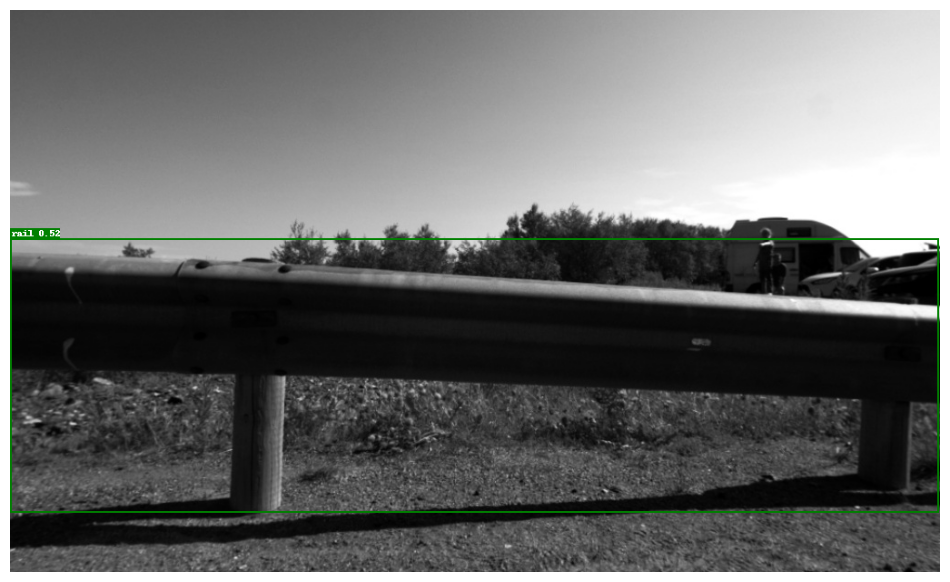

In [27]:
img = run_image(runner,"/home/emilia/objectdetection/data/Eksempelstrekning/coco/test/images/5021_RIGHT_1689251353305193216_huse.jpg")
sv.plot_image(img)